In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, SymLogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
plt.style.use('bmh')

In [3]:
conn = sqlite3.connect("../agg-data/agg_fcc.db")
df = pd.read_sql_query("select * from agg_udplatency;", conn)
df_load = pd.read_sql_query("select * from agg_dlping;", conn)
conn.close()

In [4]:
conn_loc = sqlite3.connect("../agg-data/location-data-2018-2019.db")
df_loc = pd.read_sql_query('select * from "locations"', conn_loc)
conn_loc.close()

conn_loc_carry_forward = sqlite3.connect("../agg-data/location-data-older.db")
df_tmp = pd.read_sql_query("select unitid as unit_id, cast(longitude as float) as longitude, cast(latitude as float) as latitude from locations2018;", conn_loc_carry_forward)
df_loc = pd.concat([df_loc, df_tmp], ignore_index=True)
df_tmp = pd.read_sql_query("select unitid as unit_id, cast(longitude as float) as longitude, cast(latitude as float) as latitude from locations2018;", conn_loc_carry_forward)
df_tmp['year'] = '2019'
df_loc = pd.concat([df_loc, df_tmp], ignore_index=True)
df_tmp = pd.read_sql_query("select unitid as unit_id, cast(longitude as float) as longitude, cast(latitude as float) as latitude from locations2016;", conn_loc_carry_forward)
df_tmp['year'] = '2018'
df_loc = pd.concat([df_loc, df_tmp], ignore_index=True)
df_tmp = pd.read_sql_query("select unitid as unit_id, cast(longitude as float) as longitude, cast(latitude as float) as latitude from locations2016;", conn_loc_carry_forward)
df_tmp['year'] = '2019'
df_loc = pd.concat([df_loc, df_tmp], ignore_index=True)
conn_loc_carry_forward.close()

In [5]:
conn_unit_profile = sqlite3.connect("../agg-data/unit-profile.db")
df_tech = pd.read_sql_query('select * from "unit-profile"', conn_unit_profile)

#fix AT&T IPBB
df_tech['technology'] = np.where(df_tech.isp == 'AT&T IPBB', 'DSL', df_tech.technology)
df_tech['technology'] = np.where(df_tech.technology == 'IPBB', 'DSL', df_tech.technology)
df_tech['technology'] = np.where(df_tech.technology == 'UVERSE', 'DSL', df_tech.technology)

def isp_names(df, column):
    df[column] = np.where(df[column].str.startswith("Verizon"), 'Verizon', df[column])
    df[column] = np.where(df[column] == "TimeWarner", 'Time Warner Cable', df[column])

    df[column] = np.where(df[column].str.startswith("Frontier"), 'Frontier', df[column])
    df[column] = np.where(df[column] == "Qwest", 'CenturyLink', df[column])
    df[column] = np.where(df[column].str.startswith("Cincinnati Bell"), 'Cincinnati Bell', df[column])
    df[column] = np.where(df[column].str.startswith("AT&T"), 'AT&T', df[column])
    df[column] = np.where(df[column] == "TWC", 'Time Warner Cable', df[column])
    
isp_names(df_tech, 'isp')
conn_unit_profile.close()

In [6]:
df_satellite_isps = df_tech[(df_tech.year == '2017') & (df_tech.isp.isin(['Hughes', 'Wildblue/ViaSat']))]
df_satellite_isps = df_satellite_isps[~df_satellite_isps.unit_id.isin(df_tech[df_tech.year.isin(['2019', '2018'])].unit_id.unique())]
usable_sat_units = df_satellite_isps.unit_id.unique().tolist()
usable_sat_units.remove(1273)
usable_sat_units.remove(801252)
usable_sat_units.remove(13236)
usable_sat_units.remove(999051)
usable_sat_units.remove(216686)

df_att = df_tech[(df_tech.year == '2018') & (df_tech.isp.isin(['AT&T']))]
df_att = df_att[~df_att.unit_id.isin(df_tech[df_tech.year == '2019'].unit_id.unique())]
att_probes_carry_fwd = df_att.unit_id.unique().tolist()
att_probes_carry_fwd.remove(507)
att_probes_carry_fwd.remove(5655)
att_probes_carry_fwd.remove(7460)
att_probes_carry_fwd.remove(27738)
att_probes_carry_fwd.remove(216054)
att_probes_carry_fwd.remove(216146)
att_probes_carry_fwd.remove(805166)
att_probes_carry_fwd.remove(805490)
att_probes_carry_fwd.remove(805630)
att_probes_carry_fwd.remove(805782)
att_probes_carry_fwd.remove(811954)
att_probes_carry_fwd.remove(941780)
att_probes_carry_fwd.remove(994195)
att_probes_carry_fwd.remove(994419)
att_probes_carry_fwd.remove(999719)

#Hawaiian Telcom -- remove, bought by cincinnati bell
df_hitel = df_tech[(df_tech.year == '2017') & (df_tech.isp.isin(['Hawaiian Telcom']))]
df_hitel = df_hitel[~df_hitel.unit_id.isin(df_tech[df_tech.year.isin(['2019', '2018'])].unit_id.unique())]
hit_probes_carry_fwd = df_hitel.unit_id.unique().tolist()
hit_probes_carry_fwd.remove(995125)
hit_probes_carry_fwd.remove(995121)
hit_probes_carry_fwd = []

df_tech_for_merge = pd.DataFrame()
for year in ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']:

    if year == '2012':
        df_tmp = df_tech[df_tech.year == '2012']
        df_tmp_for_append = df_tmp[df_tmp.month == '09']
        list_2012_newer_units = df_tmp_for_append.unit_id.to_list()
        list_2012_older_units = df_tmp[df_tmp.month == '04'].unit_id.to_list()
        for unit_id in list_2012_older_units:
            if not unit_id in list_2012_newer_units:
                df_tmp_for_append = pd.concat([df_tmp_for_append, df_tmp[(df_tmp.month == '04') & (df_tmp.unit_id == unit_id)]], ignore_index=True)
    elif year == '2013':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2014':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2015':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2016':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2017':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2018':
        df_tmp_for_append = df_tech[(df_tech.year == '2017') & (df_tech.unit_id.isin(usable_sat_units + hit_probes_carry_fwd))]
        df_tmp_for_append['year'] = '2018'
        df_tmp_for_append = pd.concat([df_tmp_for_append, df_tech[df_tech.year == year]], ignore_index=True)
    elif year == '2019':
        df_tmp_for_append = df_tech[(df_tech.year == '2017') & (df_tech.unit_id.isin(usable_sat_units + hit_probes_carry_fwd + att_probes_carry_fwd))]
        df_tmp_for_append['year'] = '2019'
        df_tmp_for_append = pd.concat([df_tmp_for_append, df_tech[df_tech.year == year]], ignore_index=True)
        
    df_tech_for_merge = pd.concat([df_tech_for_merge, df_tmp_for_append], ignore_index=True)

/u/home/fries/.local/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/u/home/fries/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
df_tech_for_merge['tech'] = ''
df_tech_for_merge['tech'] = np.where(df_tech_for_merge['technology'] == 'FIBER', 'F', df_tech_for_merge['tech'])
df_tech_for_merge['tech'] = np.where(df_tech_for_merge['technology'] == 'DSL', 'D', df_tech_for_merge['tech'])
df_tech_for_merge['tech'] = np.where(df_tech_for_merge['technology'] == 'CABLE', 'C', df_tech_for_merge['tech'])

df_tech_for_merge['tech'] = np.where(df_tech_for_merge['technology'] == 'SATELLITE', 'S', df_tech_for_merge['tech'])

In [8]:


df['dtime'] = pd.to_datetime(df['dtime'])
df['year'] = df['dtime'].dt.strftime('%Y')
df['date'] = df['dtime'].dt.strftime('%m-%d')






df_load['dtime'] = pd.to_datetime(df_load['dtime'])
df_load['year'] = df_load['dtime'].dt.strftime('%Y')
df_load['date'] = df_load['dtime'].dt.strftime('%m-%d')

df['med_rtt_avg'] = df['med_rtt_avg']/1000

df_load['med_rtt_avg'] = df_load['med_rtt_avg']/1000

In [9]:
df_latency = df[(df.sum_suc > 0) & (df.med_rtt_avg > 0.) & (df.year == '2019')].groupby(['unit_id', 'year'], as_index=False).agg({'med_rtt_avg':'median'})

df_latency_l = df_load[(df_load.sum_suc > 0) & (df_load.med_rtt_avg > 0.) & (df_load.year == '2019')].groupby(['unit_id', 'year'], as_index=False).agg({'med_rtt_avg':'median'})


df_latency = pd.merge(df_latency, df_loc, how='inner', on=['unit_id', 'year'])

df_latency_l = pd.merge(df_latency_l, df_loc, how='inner', on=['unit_id', 'year'])


df_latency = pd.merge(df_latency, df_tech_for_merge, how='inner', on=['unit_id', 'year'])

df_latency_l = pd.merge(df_latency_l, df_tech_for_merge, how='inner', on=['unit_id', 'year'])

df_latency = df_latency[df_latency.technology != 'MISC']
df_latency = df_latency[df_latency.technology != 'REMOVE']
df_latency = df_latency[df_latency.isp != 'Miscellaneous']



df_latency_l = df_latency_l[df_latency_l.technology != 'MISC']
df_latency_l = df_latency_l[df_latency_l.technology != 'REMOVE']
df_latency_l = df_latency_l[df_latency_l.isp != 'Miscellaneous']


df_latency['isp_full'] = df_latency['isp'] + '(' + df_latency['tech'] + ')'

df_latency_l['isp_full'] = df_latency_l['isp'] + '(' + df_latency_l['tech'] + ')'




In [10]:
df_fail = df[df.year == '2019'].groupby(['unit_id', 'dtime'], as_index=False).agg({'sum_suc':'sum', 'sum_fail':'sum'})
df_fail['sum_total'] = df_fail['sum_suc'] + df_fail['sum_fail']
df_fail['fail_perc'] = round(df_fail['sum_fail']/df_fail['sum_total']*100,1)
df_fail['year'] = df_fail['dtime'].dt.strftime('%Y')
df_fail = df_fail.groupby(['unit_id', 'year'], as_index=False).agg({'fail_perc':'median'})





df_fail_l = df_load[df_load.year == '2019'].groupby(['unit_id', 'dtime'], as_index=False).agg({'sum_suc':'sum', 'sum_fail':'sum'})
df_fail_l['sum_total'] = df_fail_l['sum_suc'] + df_fail_l['sum_fail']
df_fail_l['fail_perc'] = round(df_fail_l['sum_fail']/df_fail_l['sum_total']*100,1)
df_fail_l['year'] = df_fail_l['dtime'].dt.strftime('%Y')
df_fail_l = df_fail_l.groupby(['unit_id', 'year'], as_index=False).agg({'fail_perc':'median'})


df_fail = pd.merge(df_fail, df_loc, how='inner', on=['unit_id', 'year'])

df_fail_l = pd.merge(df_fail_l, df_loc, how='inner', on=['unit_id', 'year'])

df_fail = pd.merge(df_fail, df_tech_for_merge, how='inner', on=['unit_id', 'year'])

df_fail_l = pd.merge(df_fail_l, df_tech_for_merge, how='inner', on=['unit_id', 'year'])

df_fail = df_fail[df_fail.technology != 'MISC']
df_fail = df_fail[df_fail.technology != 'REMOVE']
df_fail = df_fail[df_fail.isp != 'Miscellaneous']



df_fail_l = df_fail_l[df_fail_l.technology != 'MISC']
df_fail_l = df_fail_l[df_fail_l.technology != 'REMOVE']
df_fail_l = df_fail_l[df_fail_l.isp != 'Miscellaneous']


df_fail['isp_full'] = df_fail['isp'] + '(' + df_fail['tech'] + ')'

df_fail_l['isp_full'] = df_fail_l['isp'] + '(' + df_fail_l['tech'] + ')'



In [11]:
def general_format(num):
    return format(num, 'g')

In [12]:
df_broadband_agg_block_MBA = pd.read_pickle("form477-2019.pkl")
df_broadband_agg_block_MBA['technology'] = np.where(df_broadband_agg_block_MBA.technology == 'IPBB', 'DSL', df_broadband_agg_block_MBA.technology)
df_broadband_agg_block_MBA['tech'] = ''
df_broadband_agg_block_MBA['tech'] = np.where(df_broadband_agg_block_MBA['technology'] == 'FIBER', 'F', df_broadband_agg_block_MBA['tech'])
df_broadband_agg_block_MBA['tech'] = np.where(df_broadband_agg_block_MBA['technology'] == 'DSL', 'D', df_broadband_agg_block_MBA['tech'])
df_broadband_agg_block_MBA['tech'] = np.where(df_broadband_agg_block_MBA['technology'] == 'CABLE', 'C', df_broadband_agg_block_MBA['tech'])

df_broadband_agg_block_MBA['tech'] = np.where(df_broadband_agg_block_MBA['technology'] == 'SATELLITE', 'S', df_broadband_agg_block_MBA['tech'])


df_broadband_agg_block_MBA['isp_full'] = df_broadband_agg_block_MBA['isp'] + '(' + df_broadband_agg_block_MBA['tech'] + ')'

/u/home/fries/.local/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


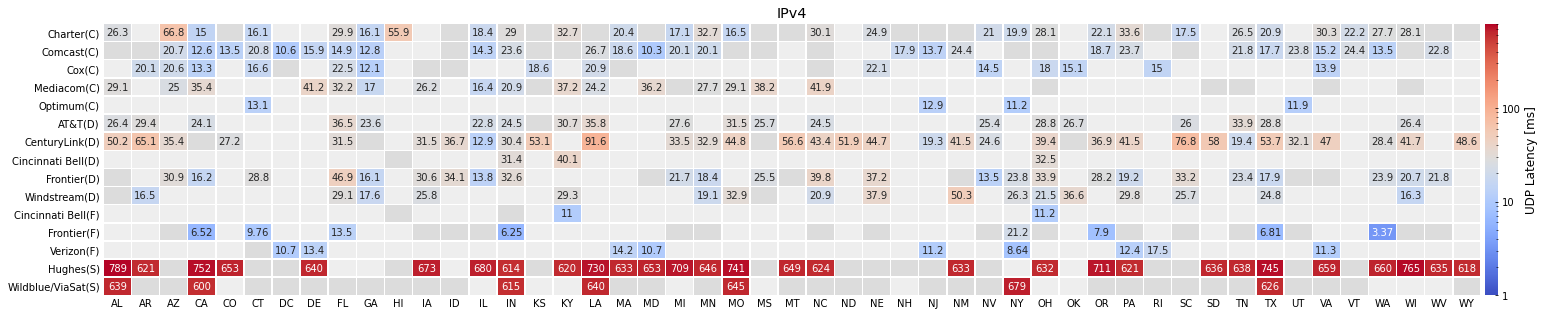

In [15]:
fig, ax = plt.subplots(figsize=(25, 5))

df_plt = df_latency[['state','isp_full','med_rtt_avg']].pivot_table(index='isp_full', columns=['state'], aggfunc=np.median)

#df_plt.columns = df_plt.columns.get_level_values(2)
df_plt.columns = df_plt.columns.droplevel(0)

index_cable = pd.Index(sorted(df_latency[(df_latency.year == '2019') & (df_latency.tech == 'C')].isp_full.unique().tolist()))
index_dsl = index_cable.union(pd.Index(sorted(df_latency[(df_latency.year == '2019') & ((df_latency.tech == 'D') | (df_latency.tech == 'I'))].isp_full.unique().tolist())), sort=False)
index_fiber = index_dsl.union(pd.Index(sorted(df_latency[(df_latency.year == '2019') & (df_latency.tech == 'F')].isp_full.unique().tolist())), sort=False)
index_satellite = index_fiber.union(pd.Index(sorted(df_latency[(df_latency.year == '2019') & (df_latency.tech == 'S')].isp_full.unique().tolist())), sort=False)

df_plt = df_plt.reindex(index=index_satellite)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)

#ticker.LogLocator(base=10)
vmax = np.ceil(df_plt.max().max()/100)*100

for index, row in df_broadband_agg_block_MBA[df_broadband_agg_block_MBA.isp_full.isin(df_latency.isp_full.unique())].groupby(['StateAbbr','isp_full']).size().reset_index()[['StateAbbr', 'isp_full']].iterrows():
    df_plt[row['StateAbbr']][row['isp_full']] = -237.0
 
sns.heatmap(df_plt[df_plt != -237.0], annot=True, cmap="coolwarm", cbar_kws={'label' : 'UDP Latency [ms]',
    'format':plt.FuncFormatter(lambda x,y: general_format(x)), 'ticks':ticker.LogLocator(base=10)},
    cbar_ax=cax, ax=ax, fmt='.3g', norm=LogNorm(), linewidths=.5, vmin=1, vmax=vmax)


sns.heatmap(df_plt[df_plt == -237.0], cbar=False, annot=False, cmap=['gainsboro'], ax=ax, linewidths=.5)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('IPv4')
fig.savefig('UDP_Latency/UDP-latency-heatmap-v4.pdf', bbox_inches='tight', format='pdf')
plt.show()

/u/home/fries/.local/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


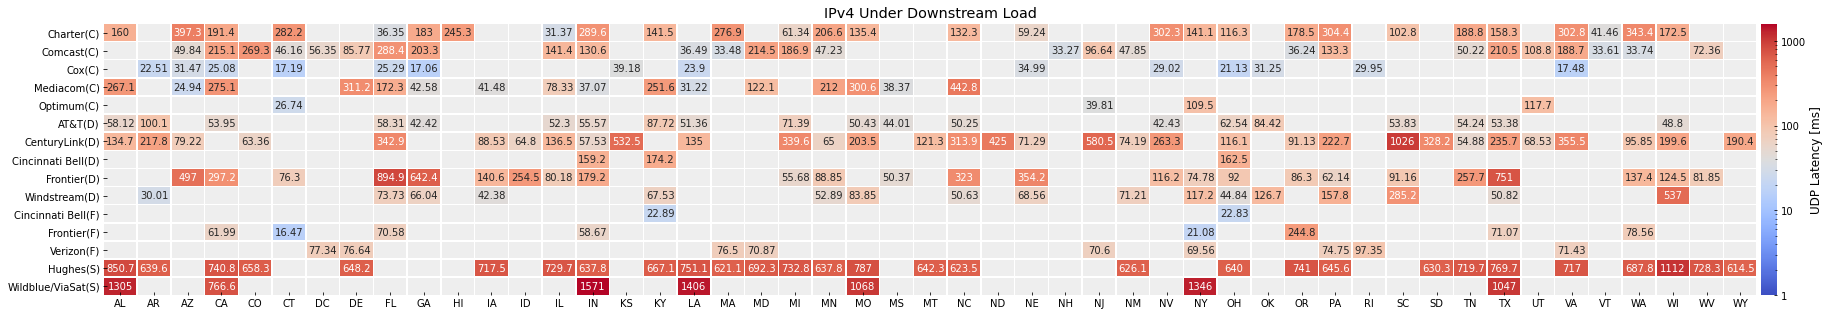

In [16]:
fig, ax = plt.subplots(figsize=(30, 5))

df_plt = df_latency_l[['state','isp_full','med_rtt_avg']].pivot_table(index='isp_full', columns=['state'], aggfunc=np.median)

#df_plt.columns = df_plt.columns.get_level_values(2)
df_plt.columns = df_plt.columns.droplevel(0)

index_cable = pd.Index(sorted(df_latency_l[(df_latency_l.year == '2019') & (df_latency_l.tech == 'C')].isp_full.unique().tolist()))
index_dsl = index_cable.union(pd.Index(sorted(df_latency_l[(df_latency_l.year == '2019') & ((df_latency_l.tech == 'D') | (df_latency_l.tech == 'I'))].isp_full.unique().tolist())), sort=False)
index_fiber = index_dsl.union(pd.Index(sorted(df_latency_l[(df_latency_l.year == '2019') & (df_latency_l.tech == 'F')].isp_full.unique().tolist())), sort=False)
index_satellite = index_fiber.union(pd.Index(sorted(df_latency_l[(df_latency_l.year == '2019') & (df_latency_l.tech == 'S')].isp_full.unique().tolist())), sort=False)

df_plt = df_plt.reindex(index=index_satellite)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)

vmax = np.ceil(df_plt.max().max()/100)*100

for index, row in df_broadband_agg_block_MBA[df_broadband_agg_block_MBA.isp_full.isin(df_latency_l.isp_full.unique())].groupby(['StateAbbr','isp_full']).size().reset_index()[['StateAbbr', 'isp_full']].iterrows():
    df_plt[row['StateAbbr']][row['isp_full']] = -237.0
 
sns.heatmap(df_plt[df_plt != -237.0], annot=True, cmap="coolwarm", cbar_kws={'label' : 'UDP Latency [ms]',
    'format':plt.FuncFormatter(lambda x,y: general_format(x)), 'ticks':ticker.LogLocator(base=10)},
    cbar_ax=cax, ax=ax, fmt='.4g', norm=LogNorm(), linewidths=.5, vmin=1, vmax=vmax)

sns.heatmap(df_plt[df_plt == -237.0], cbar=False, annot=False, cmap=['gainsboro'], ax=ax, linewidths=.5)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')


ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('IPv4 Under Downstream Load')
fig.savefig('UDP_Latency/UDP-latency-heatmap-v4-load.pdf', bbox_inches='tight', format='pdf')
plt.show()